## 2) Exploratory Analysis

### Import Libraries

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Import Dataset

In [92]:
dataset = pd.read_csv('/content/drive/MyDrive/ML Projects/1. Predictive Maintenance Project/data.csv')
print('Features are non null values and data types')
print(dataset.info())
print('\n Check for the duplicate values ', dataset['Product ID'].unique().shape[0]!=dataset.shape[0] )

Features are non null values and data types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None

 Check for the duplicate values  False


No duplicate values | No missing data | 6 columns numeric data | 3 columns categorical data

In [93]:
# set numeric column dtype into float type
dataset['Tool wear [min]'] = dataset['Tool wear [min]'].astype('float64')
dataset['Rotational speed [rpm]'] = dataset['Rotational speed [rpm]'].astype('float64')

In [94]:
# rename the feature names
dataset.rename(mapper={'Air temperature [K]':'Air temperature',
                       'Process temperature [K]':'Process temperature',
                       'Rotational speed [rpm]':'Rotational speed',
                       'Torque [Nm]':'Torque',
                       'Tool wear [min]':'Tool wear'}, axis = 1, inplace = True)

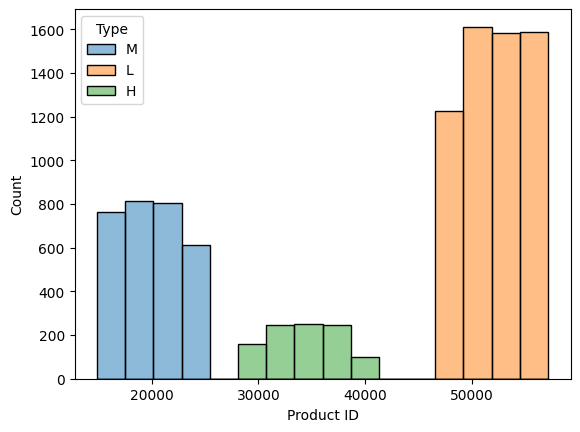

In [95]:
# dataset['Product ID'].unique().shape[0]!=dataset.shape
# remove the first character and set numeric value

dataset['Product ID'] = dataset['Product ID'].apply(lambda x : x[1:])
dataset['Product ID'] = pd.to_numeric(dataset['Product ID'])

# histogram of product id
sns.histplot(data = dataset, x='Product ID', hue = 'Type')
plt.show()

In [96]:
# Dropping unwanted columns i.e ID columns

df = dataset.copy()
df.drop(columns = ['UDI', 'Product ID'], inplace = True)
df.head()


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
0,M,298.1,308.6,1551.0,42.8,0.0,0,No Failure
1,L,298.2,308.7,1408.0,46.3,3.0,0,No Failure
2,L,298.1,308.5,1498.0,49.4,5.0,0,No Failure
3,L,298.2,308.6,1433.0,39.5,7.0,0,No Failure
4,L,298.2,308.7,1408.0,40.0,9.0,0,No Failure


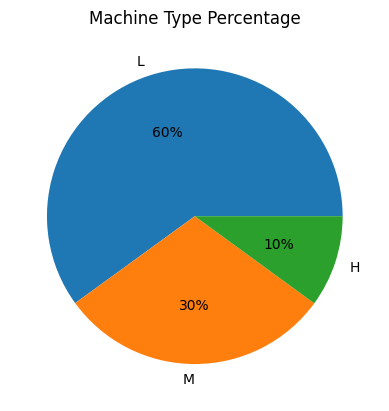

In [97]:
# following pie chart shows the percentages of machine types

value = dataset['Type'].value_counts()

type_percentage = 100 * value / dataset['Type'].shape[0]
labels = type_percentage.index
x = type_percentage.array
plt.pie(x,labels = labels,colors = sns.color_palette('tab10')[0:3], autopct = "%0.0f%%")
plt.title('Machine Type Percentage')
plt.show()


In [98]:
# Target Anomalies

# in this we observe the distribution of target and find the any inbalances and correct them before dividing dataset.

# first anamoly respect to dataset discriptions is that when failure is random (RNF)

# machine failure feature is not set to 1.

# creating list of features and target names

features = [col for col in df.columns if df[col].dtype=='float64' or col == 'Type']
target = ['Target', 'Failure Type']

# portion of the data when RNF = 1
idx_RNF = df.loc[df['Failure Type'] == 'Random Failures'].index
df.loc[idx_RNF, target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [99]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [100]:
# the above machine failure observation its showing only 18.
# so random nature we can't able to predictable so we decided to remove these rows

first_drop = df.loc[idx_RNF, target].shape[0]
print('Number of observations where RNF = 1 but machine failure = 0 :', first_drop)

# dropping corresponding observations and RNF column
df.drop(index = idx_RNF, inplace = True)


Number of observations where RNF = 1 but machine failure = 0 : 18


In [101]:
# moving forward we observe that 9 observations machine failures are set to 1.
# when all types of failure are set to 0.
# we can't understand if there is a really failure or not. So lets remove these observations too.

# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target'] == 1) & (df['Failure Type'] == 'No Failure')].index

second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations :',second_drop)

display(df.loc[idx_ambiguous, target])

df.drop(index = idx_ambiguous, inplace = True)

Number of ambiguous observations : 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [102]:
# lets check the global percentage of removed observations

print('Global percentage of removed observations : ',round((100*(first_drop+second_drop)) / (df.shape[0]),2))

df.reset_index(drop = True, inplace = True)

Global percentage of removed observations :  0.27


In [103]:
# our actions did not alterate the orginal dataset

In [104]:
# outliers inspection

# in this section we checking outliers which usually misleading the machine learning algorithms.

# to check this we have to start with statistical report to better understand

df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [105]:
features

['Type',
 'Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear']

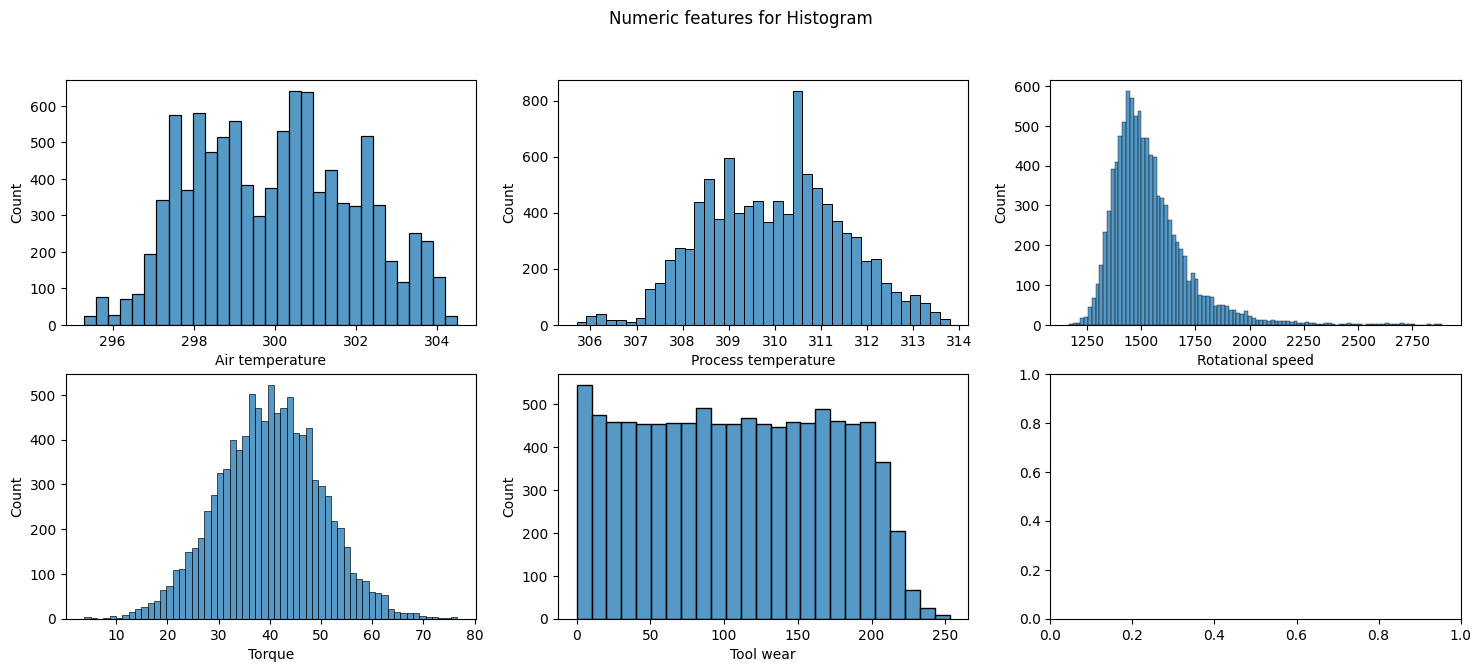

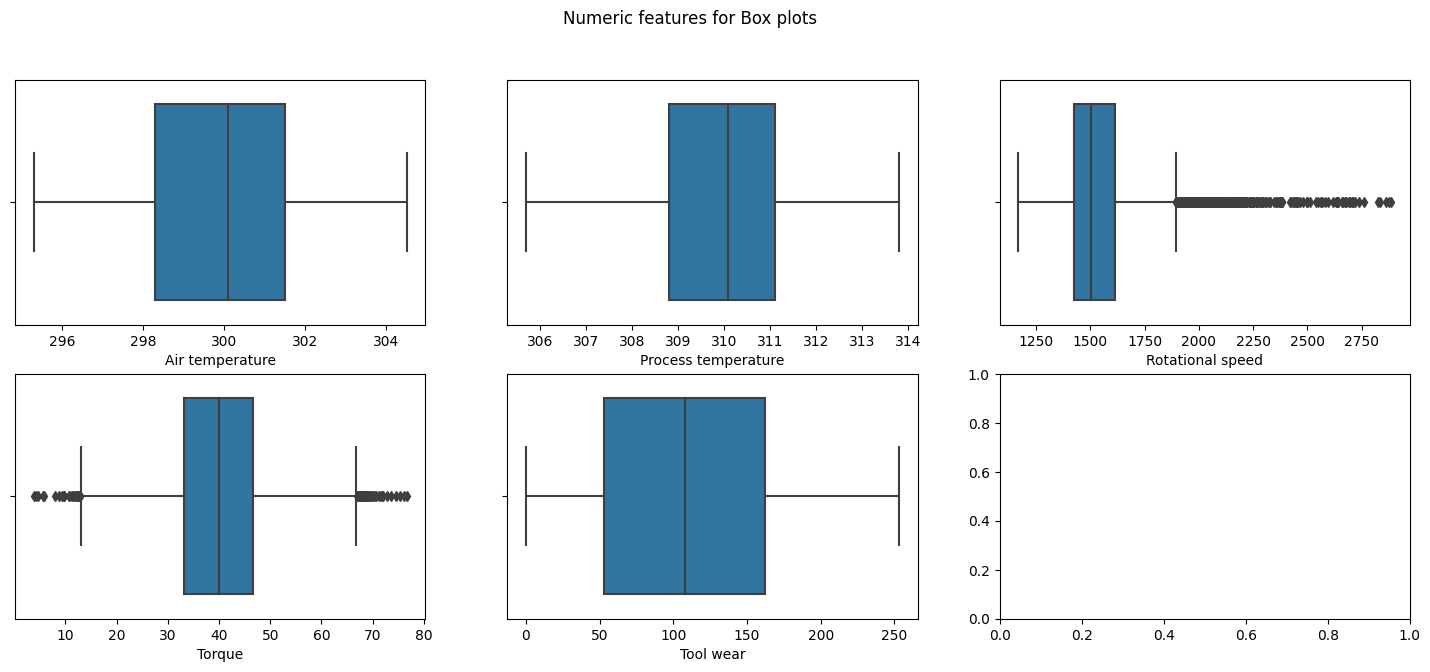

In [106]:
# statistical observation results:

# we gauss that torque and rotational speed feature are outliers because of maximum is very diffrent from third quartile

# to understand this better, way we using now box plots and using histograms shows the distributions.

num_features = [feature for feature in features if df[feature].dtype == 'float64']

# histogram for numeric features

fig, axs = plt.subplots(nrows = 2, ncols= 3, figsize= (18,7))
fig.suptitle('Numeric features for Histogram')

for j, feature in enumerate(num_features):
  sns.histplot(ax=axs[j//3, j-3*(j//3)], data = df, x = feature)
plt.show()

# box plots for numeric features

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (18,7))
fig.suptitle('Numeric features for Box plots')

for i, feature in enumerate(num_features):
  sns.boxplot(ax = axs[i//3, i-3*(i//3)], data = df, x=feature)
plt.show()

In [107]:
# above observation results : torque and rotational speed have outlier values. so we keep this values as of now.
# we have to decide whether we have to keep or remove these values after considering other aspects.

In [108]:
# Resampling with SMOTE (synthetic minority oversampling technique)

# with help of resampling we can change the distribution data by adding, removing and modifying process.
# resampling commonly used for class imbalance, which occurs when there is significant diffrence between data points and different class

# why we using SMOTE?

# example : if two minority data points are close to each other, SMOTE would create a new data point that is between them


Failures percentage in data :  3.31
Causes involved in machine failures


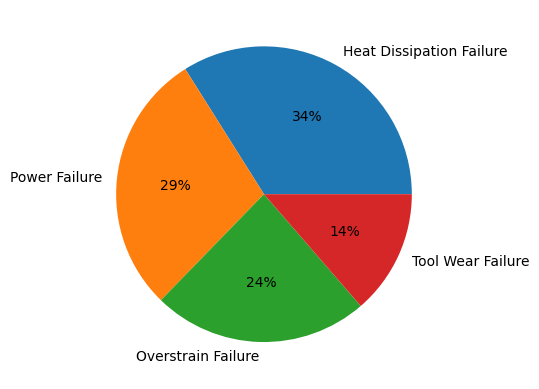

In [109]:
# portion of where there is failure and causes by percentage

idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = round((100*df_fail['Failure Type'].value_counts()) / (df_fail['Failure Type'].shape[0]),2)

print('Failures percentage in data : ', round(100*df['Target'].sum() / df.shape[0],2))

# pie plot
print('Causes involved in machine failures')

plt.pie(x = df_fail_percentage.array, labels = df_fail_percentage.index.array, colors = sns.color_palette('tab10')[0:4], autopct = "%0.0f%%")
plt.show()

In [110]:
# Therefore we use the SMOTE procedure to generate new samples, which is very much like slightly moving -
# the data point in the direction of its neighbors. This way, the synthetic data point is not an exact copy of -
# an existing data point but we can also be sure that it is also not too different from the known observations in -
# the minority class. To be more precise, the SMOTE procedure works as follows: it draws a random sample from the minority class -
# and for the observations in this sample, identifies the k nearest neighbors. It will then take one of those neighbors and identify -
# the vector between the current data point and the selected neighbor. The vector will be multiplied by a random number between 0 and 1 -
# and the synthetic data point is obtained by adding this vector to the current data point.

In [111]:
df_fail_percentage.index.array

<PandasArray>
['Heat Dissipation Failure',            'Power Failure',
       'Overstrain Failure',        'Tool Wear Failure']
Length: 4, dtype: object

In [112]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# n_working must represent with 80% desired length of resampled dataframe.

n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working / 0.8)
spc = round((desired_length - n_working )/ 4) # SPC samples per class

# Resampling

balance_cause = {'No Failure' : n_working,
                 'Overstrain Failure': spc,
                 'Power Failure': spc,
                 'Tool Wear Failure': spc,
                 'Heat Dissipation Failure' : spc}

sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)

df_res, y_res = sm.fit_resample(df,df['Failure Type'])


In [113]:
# Comparision after resampling

# portion of def_res where there is failure causes and percentage

idx_fail_res = df_res.loc[df_res['Failure Type']!='No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/ df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling : ',  round(df_res_fail.shape[0]*100/df_res.shape[0],2))
print('SMOTE Resampled Failures Percentage : ', round(df_res_fail.shape[0] * 100 / df_res.shape[0]))

Percentage increment of observations after oversampling :  20.01
SMOTE Resampled Failures Percentage :  20


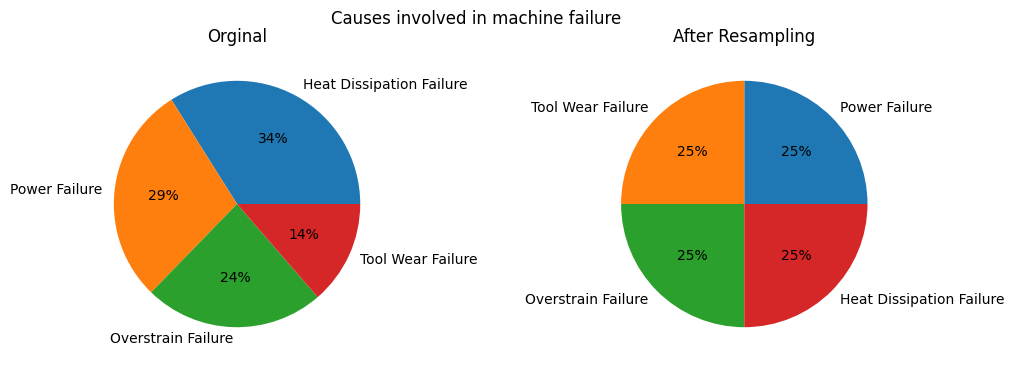

In [114]:
# pie plot

fig, axs = plt.subplots(ncols=2, figsize = (12,4))
fig.suptitle('Causes involved in machine failure')

axs[0].pie(x = df_fail_percentage.array, labels = df_fail_percentage.index.array,
           colors = sns.color_palette('tab10')[0:4], autopct = "%0.0f%%")

axs[1].pie(x = fail_res_percentage.array, labels = fail_res_percentage.index.array,
           colors =  sns.color_palette('tab10')[0:4],autopct = "%0.0f%%")

axs[0].title.set_text('Orginal')
axs[1].title.set_text('After Resampling')

plt.show()

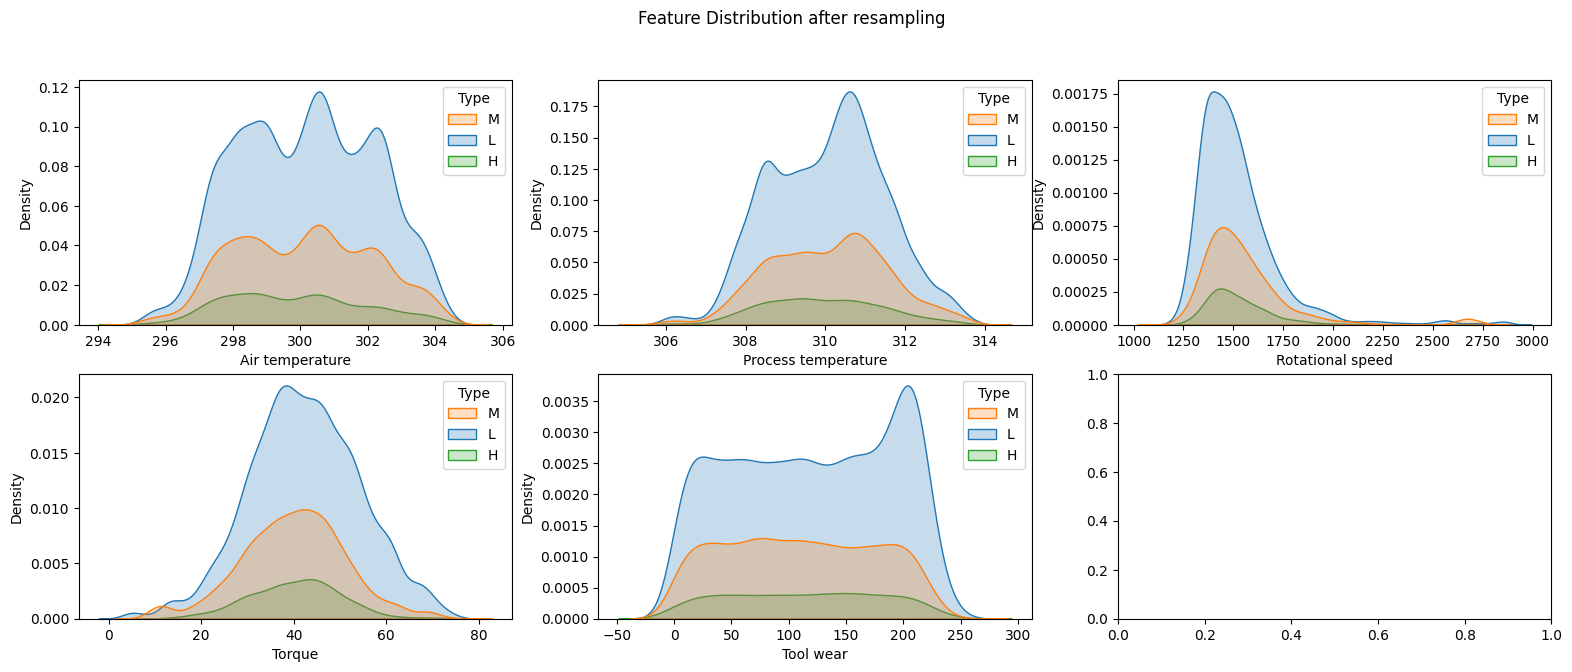

In [115]:
# we have to find which (L, H, M) failure is mostly happen in the failure type
# so that we using kdeplot its shows which failure is mostly happen

# kdeplot

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Feature Distribution after resampling')

custom_palette = {'L':'tab:blue','M':'tab:orange','H':'tab:green'}
for i, feature in enumerate(num_features):
  sns.kdeplot(ax = axs[i//3, i-3*(i//3)], data = df_res, x = feature, hue = 'Type', fill= True, palette = custom_palette)

plt.show()


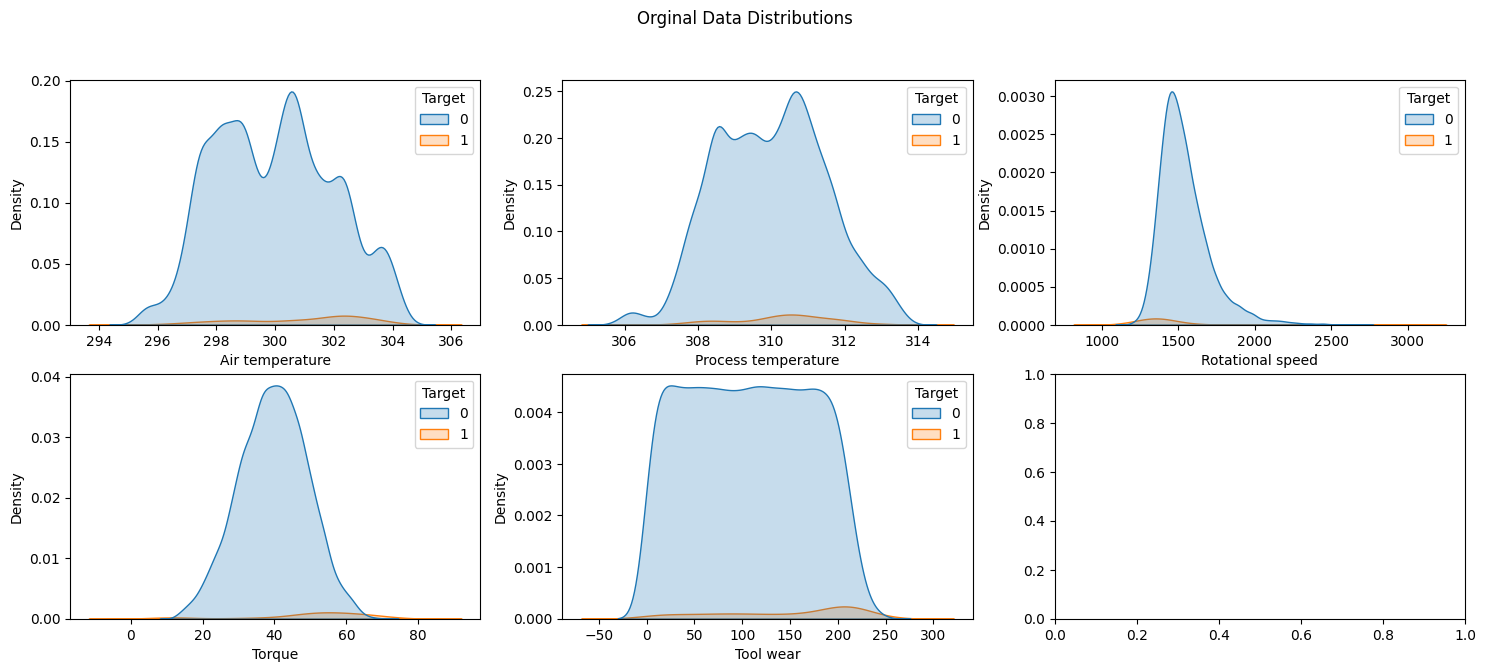

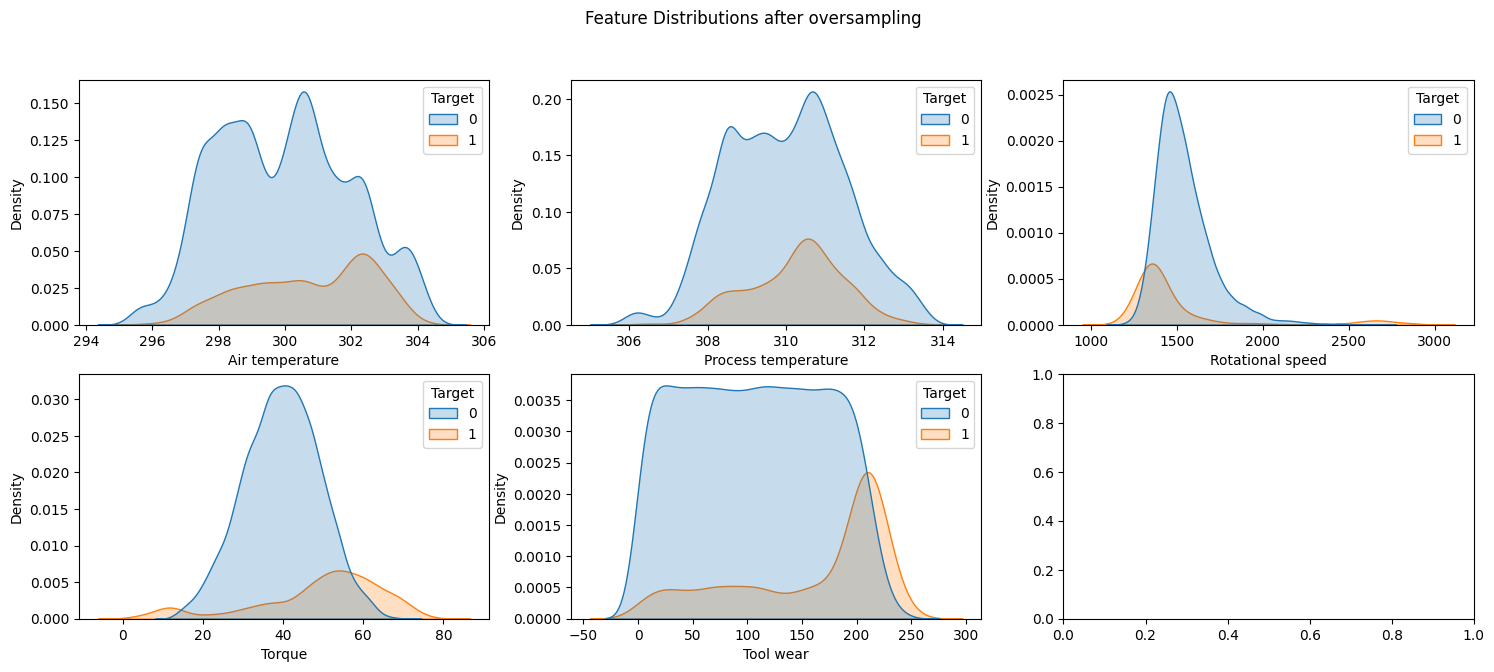

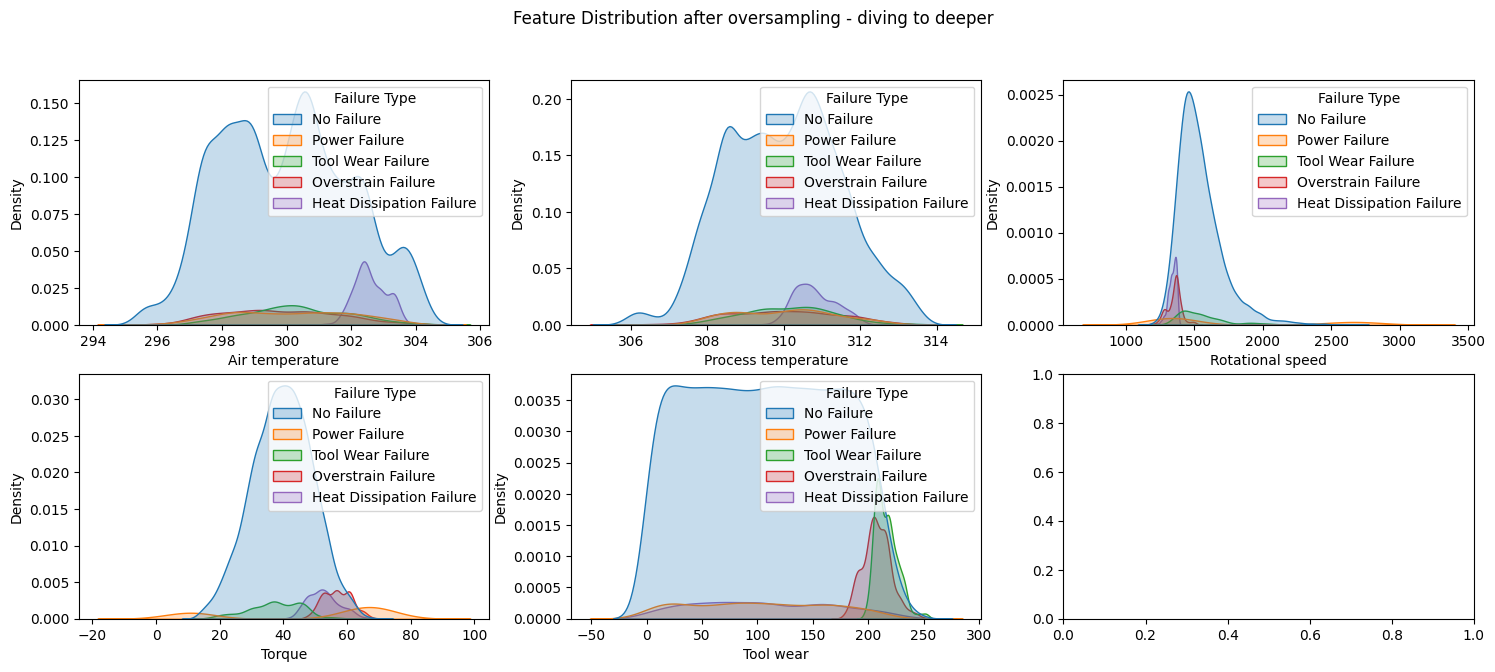

In [116]:
# lets look at how distribution features are changed

# kdeplot at numeric features

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (18,7))
fig.suptitle('Orginal Data Distributions')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
  sns.kdeplot(ax = axs[j//3, j-3*(j//3)], data = df, x = feature, hue = 'Target', fill = True, palette = 'tab10')
plt.show()


# kdeplot numeric featuers after resampling

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (18,7))
fig.suptitle('Feature Distributions after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
  sns.kdeplot(ax = axs[j//3, j-3*(j//3)], data = df_res, x = feature, hue = 'Target', fill = True, palette = 'tab10')
plt.show()


# kdeplot numeric features after resampling - diving to deeper
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (18,7))
fig.suptitle('Feature Distribution after oversampling - diving to deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
  sns.kdeplot(ax = axs[j//3, j-3*(j//3)], data = df_res, x = feature, hue = df_res['Failure Type'], fill = True, palette = 'tab10')
plt.show()


In [117]:
# It should also be noted that in Rotational Speed, Torque and Tool Wear the observations
# relating to failures have a density peak in extreme zones of the distribution

# symmetrical behavior is recognized in Rotational Speed and Torque -
# while in Tool Wear a clear separation is observed between-
# PWF and HDF failures on lower values, and -
# the peaks that are found at higher values relative to TWF and OSF.

### Feature scaling and encoding

- First, we apply a label encoding to the categorical columns, since Type is an ordinal feature and Cause must be represented in one column. The mapping follows this scheme: Type: {L=0, M=1, H=2} Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}

- Second, we perform the scaling of the columns with StandardScaler. This is particularly useful for the good working of methods that rely on the metric space, such as PCA and KNN. It has been also verified that using StandardScaler leads to slightly better performances than using MinMaxScaler.

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L':0,'M':1,'H':2}
cause_dict = {'No Failure':0,
              'Power Failure':1,
              'Overstrain Failure':2,
              'Heat Dissipation Failure':3,
              'Tool Wear Failure':4}

df_pre = df_res.copy()
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12055 entries, 0 to 12054
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 12055 non-null  object 
 1   Air temperature      12055 non-null  float64
 2   Process temperature  12055 non-null  float64
 3   Rotational speed     12055 non-null  float64
 4   Torque               12055 non-null  float64
 5   Tool wear            12055 non-null  float64
 6   Target               12055 non-null  int64  
 7   Failure Type         12055 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 753.6+ KB


In [119]:
print(num_features)

['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']


In [120]:
# We can see that Type and Failure Type columns type is object i.e categorical columns
# so we need to encoding the that Type and Failure Type columns.

# Encoding
df_pre['Type'].replace(to_replace = type_dict, inplace = True)
df_pre['Failure Type'].replace(to_replace = cause_dict, inplace = True)

# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features])

In [121]:
len(num_features)

5

In [122]:
# PCA and Correlation Heat Map

# we run PCA display the data instead of making feature selection

pca = PCA(n_components = len(num_features))
X_pca = pd.DataFrame(data = pca.fit_transform(df_pre[num_features]),columns = ['PC'+str(i+1) for i in range(len(num_features))])

var_exp = pd.Series(data = 100*pca.explained_variance_ratio_, index = ['PC'+str(i+1) for i in range(len(num_features))])

print('Explained variance ratio per componet : ', round(var_exp,2), sep = '\n')

print('Explained variance ratio three component : '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per componet : 
PC1    37.69
PC2    36.81
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio three component : 94.34


In [123]:
# we can see that first 3 components are almost informations available
# so we project them 3 dimensional space

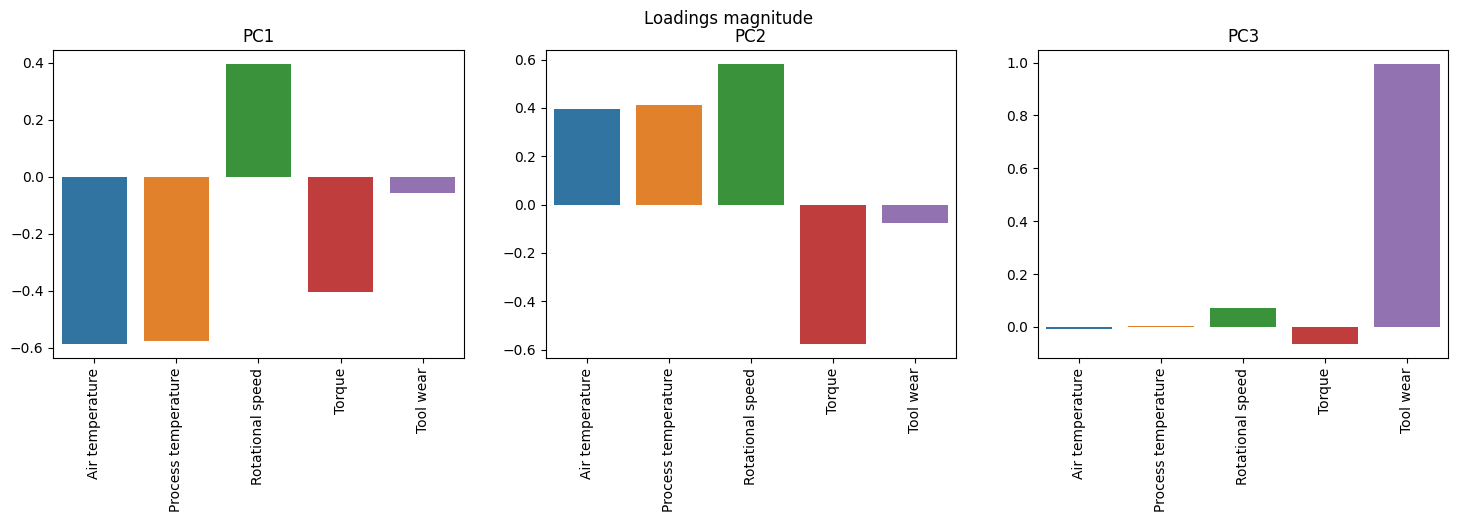

In [124]:
# PCA for data visualization

pca3 = PCA(n_components = 3)
X_pca3 = pd.DataFrame(data = pca3.fit_transform(df_pre[num_features]), columns = ['PC1','PC2','PC3'])

# loading analytics
fig, axs = plt.subplots(ncols=3, figsize= (18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data = pca3.components_, columns = num_features)

for j in range(3):
  ax = axs[j]
  sns.barplot(ax =ax , x = pca_loadings.columns, y = pca_loadings.values[j])
  ax.tick_params(axis='x', rotation = 90)
  ax.title.set_text("PC"+str(j+1))

plt.show()

In [125]:
# observation results

# PC1 : air temperature and process temperature are closely corelated
# PC2 : it can identified machine power. which is rotational speed and torque
# PC3 : identifible by the tool wear

In [126]:
X_pca3.rename(mapper = {
              'PC1':'Temperature',
              'PC2':'Power',
              'PC3':'Tool Wear'}, axis=1, inplace = True)

In [127]:
df_pre['Failure Type'].unique()

array([0, 1, 4, 2, 3])

In [128]:
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',
                                  3:'tab:red',4:'tab:purple'})
color.append(col)


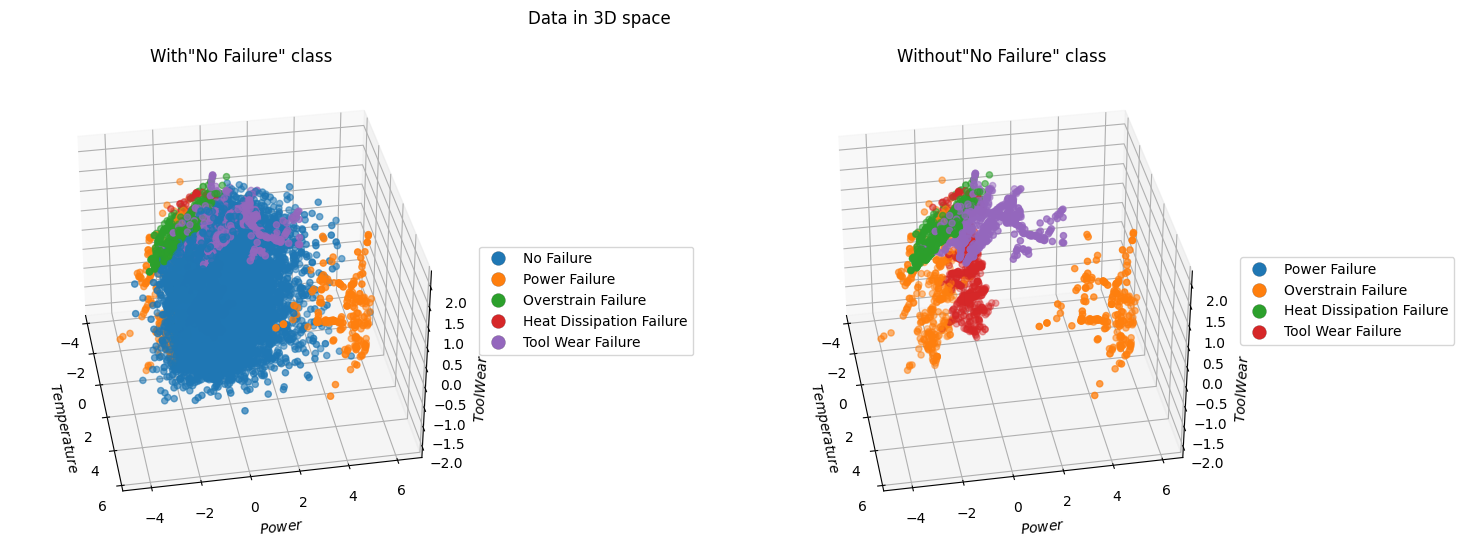

In [129]:
# PCA Plot



idx_w = col[col=='tab:blue'].index
color.append(col.drop(idx_w))

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

labelTups = [('No Failure','tab:blue'),
             ('Power Failure','tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure','tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize = (18,6))
fig.suptitle('Data in 3D space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx, idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx, 'Temperature'],
                    X_pca3.loc[idx, 'Power'],
                    X_pca3.loc[idx, 'Tool Wear'], c=color[j])

    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With' + str(j*'out') + '"No Failure" class')
    ax.view_init(35, -10)
    custom_lines = [plt.Line2D([], [], ls="", marker='.',
                           mec='k', mfc=c, mew=.1, ms=20) for c in colors]

    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]], loc='center left', bbox_to_anchor=(1.0, .5))

plt.show()

In [130]:
# above observation notes:

# tool wear failure is separated by all others, its mostly depend on the PC3 (Tool Wear)

# power failure is occupies two extreme bands along the PC2 (Power)

# The OSF and HDF classes are less separated than the others even if it can be observed
# that the first is characterized by a high Tool Wear and low power while the second is
# characterized by a high temperature and a low power.

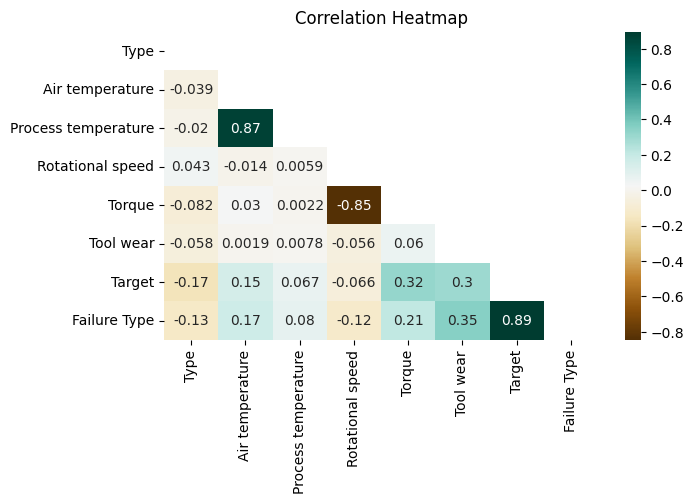

In [131]:
# Correlation with heatmap

plt.figure(figsize= (7,4))
sns.heatmap(data = df_pre.corr(), mask = np.triu(df_pre.corr()),annot = True, cmap = 'BrBG')
plt.title('Correlation Heatmap')
plt.show()

In [132]:
# observation results:

# we observe that the features related to temperature, as well as those related to power, are widely correlated.
# Furthermore, Tool Wear correlates well with both of our targets, confirming what we have observed by studying PCA.
# Finally, a less strong correlation is also observed between the torsion and the two targets.


metrics

- Accuracy_Score
- F1_Score
- AUC
- Confusion matrix
- Fbeta

## 3) Binary Task

In [133]:
# in this section we finding the whether machine is going to be failure or not.

# here we following this approach 80 - train | 10 - validation | 10 - test
# 1. Logistic regression
# 2. K-Nearest Neigbors
# 3. support vector machine
# 4. random forest
# 5. XGBoost

In [134]:
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.metrics import fbeta_score, roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

In [135]:
X, y = df_pre[features], df_pre[['Target','Failure Type']]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=42 )

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, stratify=y_train_val['Failure Type'],
                                                  random_state=42)

**User defined functions for to evalute the predictions**

*Metrics from sklearn => confusion_matrix, accuracy_score, f1_score and AUC*

***function eval_preds***
***(X, y_true, y_pred, task)***

* X , data used to estimate the class probabilities ( paired with y_true )
* y_true, ground truth with two columns
* y_pred, predictions
* task , ***'binary' | 'multi class'***


- multi_class = 'ovr' (One-vs-Rest) parameter from auc:

This is the default behavior. For each class, it treats that class as the positive class and the rest as the negative class. It then calculates the ROC AUC for each class independently. This results in a set of binary ROC AUC scores, one for each class.

- why we using beta parameter ?

The beta parameter determines the weight of recall in the combined
 score. beta < 1 lends more weight to precision, while beta > 1
favors recall (beta -> 0 considers only precision, beta -> +inf
only recall).



In [152]:
# Evaluate the predictions

def eval_preds(model, X, y_true, y_pred, task):
  if task == 'binary':

    # extract the task target
    y_true = y_true['Target']
    cm = confusion_matrix(y_true, y_pred)

    # probability of minority class
    proba = model.predict_proba(X)[:,1]

    # metrics
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, proba)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)

  elif task == 'multi_class':

    # extract the task target
    y_true = y_true['Failure Type']
    cm = confusion_matrix(y_true, y_pred)

    # probability
    proba = model.predict_proba(X)

    # metrics
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, proba, multi_class = 'ovr', average = 'weighted')
    f1  = f1_score(y_true, y_pred, average = 'weighted')
    f2  = fbeta_score(y_true, y_pred, beta=2, average = 'weighted')

  metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
  metrics = round(metrics,3)
  return cm, metrics


**User defined functions for to tune and fit the parameters**


***tune_and_fit***
***(clf, X, y, params, task)***

* clf. estimator
* X, y = X_train, y_train
* params = parameters grid for GridSearch
* task , ***'binary' | 'multi class'**

In [161]:
# Tune and fit the paramterts

def tune_and_fit(clf, X, y, params, task):

  if task == 'binary':

    f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
    start_time = time.time()

    grid_model = GridSearchCV(clf, param_grid = params, cv=5, scoring = f2_scorer)
    grid_model.fit(X, y['Target'])

  elif task == 'multi_class':
    f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
    start_time = time.time()

    grid_model = GridSearchCV(clf, param_grid=params, cv=5, scoring = f2_scorer)
    grid_model.fit(X, y['Failure Type'])

  print('Best Params : ', grid_model.best_params_)

  # printing the training time
  train_time = time.time() - start_time
  mins = int(train_time//60)

  print('Training time : '+str(mins)+'m '+str(round(train_time - mins*60))+'s')

  return grid_model

**User defined functions for to predict and evaluate**

makes the predictions by using tuned classifiers.

then eval_preds to compute the relative metrics

returns:

- y_pred, dataframe containing the prediction of each model
- cm_list, confusion matrix list
- metrics, dataframe containing the metrics


***predict_and_evaluate***
***(fitted_models,X, y_true, clf_str, task)***

*** input fields**
* fitted_models, fitted the estimators
* X, data used to make predictions
* y_true, true values of target
* clf_str, list containing the estimators names
* task , ***'binary' | 'multi class'**

In [138]:
# predict and evaluate by using tuned classifiers

def predict_and_evaluate(fitted_models, X, y_true, clf_str, task):

  cm_dict = {key:np.nan for key in clf_str}
  metrics = pd.DataFrame(columns = clf_str)
  y_pred = pd.DataFrame(columns = clf_str)

  for fit_model, model_name in zip(fitted_models, clf_str):

    # update the predictions
    y_pred[model_name] = fit_model.predict(X)

    # metrics
    if task == 'binary':
      cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)

    elif task == 'multi_class':
      cm, scores = eval_preds(fit_model, X, y_true, y_pred[model_name], task)

   # update the confusion matrix and metrics
    cm_dict[model_name] = cm
    metrics[model_name] = scores

  return y_pred, cm_dict, metrics


**User defined functions for to fit_models**

fit the estimators on the multiple classifiers


***fit_models***
***(clf, clf_str, X_train, X_val, y_train, y_val)***

*** input fields**
* clf, estimators
* clf_str, list containing the estimators names
* X_train and y_train used to train the models
* X_val, y_val used to validate the model

In [139]:
# fit the models

def fit_models(clf, clf_str, X_train, X_val, y_train, y_val):

  metrics = pd.DataFrame(columns = clf_str)

  for model, model_name in zip(clf, clf_str):
    model.fit(X_train, y_train['Target'])
    y_val_pred = model.predict(X_val)
    metrics[model_name] = eval_preds(model, X_val, y_val, y_val_pred, 'binary')[1]

  return metrics

### feature selction attempts

- in heatmap we can see that process temperatuer and air temperature are positively correlated

- torque and rotational speed are negatively correlated.

- so removing these columns are bad idea, we can loss the important information.

- better combined them to get the resonable information

> without tuning the following parameters

- orginal one
- the one obtained by removing the " Process temperature " and " Air temperature " columns, replacing them with a column their product

- the one obtained by removing the " Torque " and "
Rotational Speed " columns, replacing them with a column their product

- combine previous operations

In [140]:
# Models

lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability = True)
rfc = RandomForestClassifier()
xgb = XGBClassifier()

clf = [lr, knn, svc, rfc, xgb]
clf_str = ['LR','KNN', 'SVC', 'RFC', 'XGB']

# fit on raw train

metrics_0 = fit_models(clf, clf_str, X_train, X_val, y_train, y_val)

# fit on the temperature on the product train
XX_train = X_train.drop(columns=['Air temperature','Process temperature'])
XX_val = X_val.drop(columns=['Air temperature', 'Process temperature'])
XX_train['Temperature'] = X_train['Air temperature'] * X_train['Process temperature']
XX_val['Temperature'] = X_val['Air temperature'] * X_val['Process temperature']
metrics_1 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# fit the power on the product train
XX_train = X_train.drop(columns=['Torque', 'Rotational speed'])
XX_val = X_val.drop(columns=['Torque', 'Rotational speed'])
XX_train['Power'] = X_train['Torque'] * X_train['Rotational speed']
XX_val['Power'] = X_val['Torque'] * X_val['Rotational speed']
metrics_2 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# fit the both products train
XX_train = X_train.drop(columns=['Air temperature','Process temperature','Torque','Rotational speed'])
XX_val = X_val.drop(columns=['Air temperature','Process temperature','Torque','Rotational speed'])
XX_train['Temperature'] = X_train['Air temperature'] * X_train['Process temperature']
XX_val['Temperature'] = X_val['Air temperature'] * X_val['Process temperature']
XX_train['Power'] = X_train['Torque'] * X_train['Rotational speed']
XX_val['Power'] = X_val['Torque'] * X_val['Rotational speed']
metrics_3 = fit_models(clf,clf_str, XX_train, XX_val, y_train, y_val)


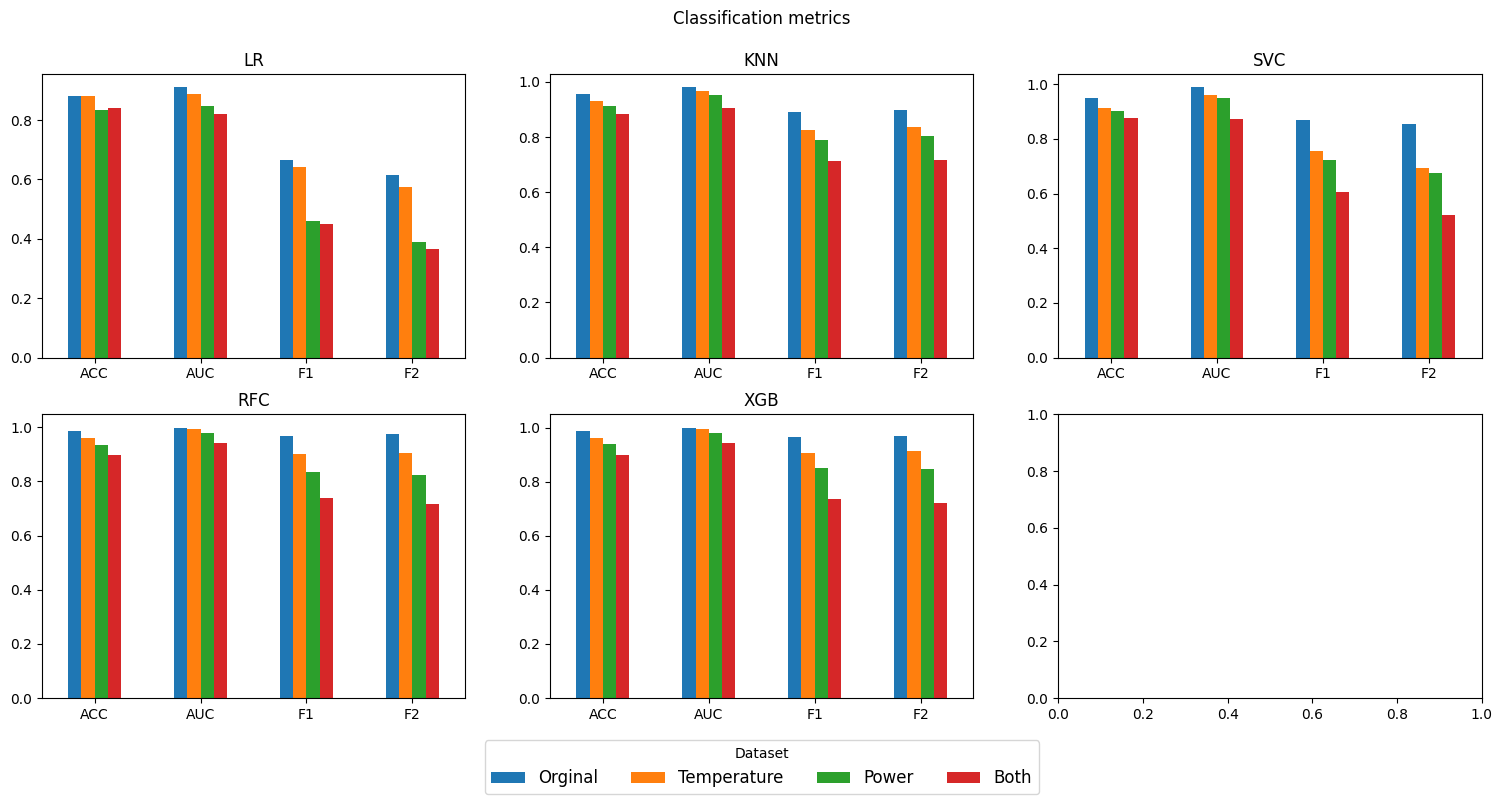

In [141]:
# classification metrics bar plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')

for j, model in enumerate(clf_str):
  ax = axs[j//3,j-3*(j//3)]
  model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],
                                     metrics_2[model],metrics_3[model]])
  model_metrics.index = ['Orginal','Temperature', 'Power', 'Both']
  model_metrics.transpose().plot(ax=ax, kind='bar', rot=0)
  ax.title.set_text(model)
  ax.get_legend().remove()

fig.subplots_adjust(top=0.9, left=0.1, bottom=0.12, right = 0.9)
axs.flatten()[-2].legend(title='Dataset', loc='upper center', bbox_to_anchor = (0.5,-0.12), ncols=4, fontsize=12)
plt.show()


- we observe that all the models applied to the entire dataset perform better than when they are applied to the ones created by reducing the number of features

- he best performances and the modest number of features from which our dataset is composed encourage us to opt to avoid the feature selection step

### Logistic Regression Benchmark

Validation set metrics : 
ACC    0.881
AUC    0.910
F1     0.664
F2     0.615
dtype: float64
Test set metrics : 
ACC    0.872
AUC    0.897
F1     0.626
F2     0.568
dtype: float64


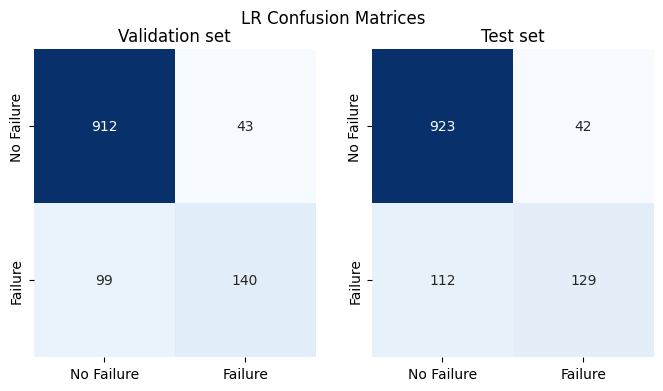

,feature,odds
4,Torque,17.128539
3,Rotational speed,9.628642
1,Air temperature,4.592085
5,Tool wear,3.624881
0,Type,0.545124
2,Process temperature,0.347318


In [142]:
# make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])

y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# metrics

cm_val_lr, metrics_val_lr = eval_preds(lr, X_val, y_val, y_val_lr, 'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr, X_test, y_test, y_test_lr, 'binary')

print('Validation set metrics : ',metrics_val_lr, sep='\n')
print('Test set metrics : ', metrics_test_lr, sep='\n')


cm_labels = ['No Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]

# show confusion matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')

for j, title in enumerate(['Validation set','Test set']):
  ax = axs[j]
  sns.heatmap(ax=ax, data = cm_lr[j], annot = True, fmt = 'd', cmap = 'Blues', cbar = False)
  axs[j].title.set_text(title)
  axs[j].set_xticklabels(cm_labels)
  axs[j].set_yticklabels(cm_labels)
plt.show()

# odds for interpretation
d = {'feature':X_train.columns, 'odds':np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending = False)
odds_df

> observation results

- In particular, an unrealistically high importance is given to Torque and Rotational Speed.
- that the first four features have a significantly greater relevance than the last two

In [143]:
# Models

knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier()

clf = [knn, svc, rfc, xgb]
clf_str = ['KNN', 'SVC', 'RFC', 'XGB']

# parameters for grid serach

knn_params = {'n_neighbors':[1,3,5,8,10]}

svc_params = {'C':[1,10,100],
              'gamma':[0.1,1],
              'kernel':['rbf'],
              'probability':[True],
              'random_state':[0]}

rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}

xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}

params = pd.Series(data=[knn_params, svc_params, rfc_params, xgb_params], index=clf)


In [144]:
# tune hyperparametrs with gridsearch (estimated time 8m)

print('GridSearch Start')
fitted_models_binary = []

for model, model_name in zip(clf, clf_str):
  print('Training '+str(model_name))
  fit_model = tune_and_fit(model, X_train, y_train, params[model], 'binary')
  fitted_models_binary.append(fit_model)

GridSearch Start
Training KNN
Best Params :  {'n_neighbors': 1}
Training time : 0m 5s
Training SVC
Best Params :  {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time : 2m 14s
Training RFC
Best Params :  {'max_depth': 10, 'n_estimators': 100, 'random_state': 0}
Training time : 3m 17s
Training XGB
Best Params :  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic'}
Training time : 1m 1s


In [145]:
# create the evaluation metrics

task = 'binary'

y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(fitted_models_binary,
                                                            X_val, y_val, clf_str, task )

y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(fitted_models_binary,
                                                               X_test, y_test, clf_str, task)


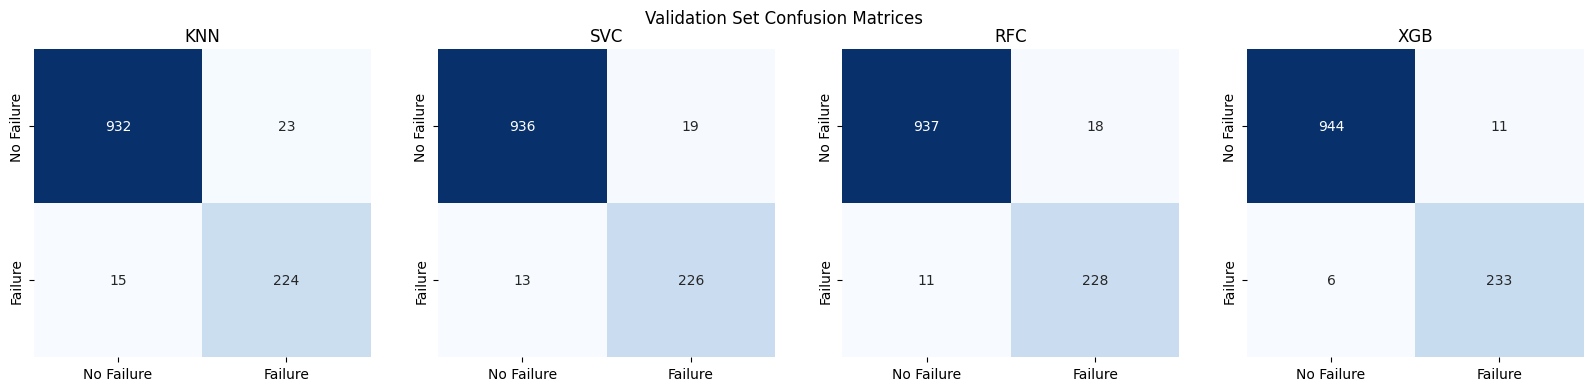

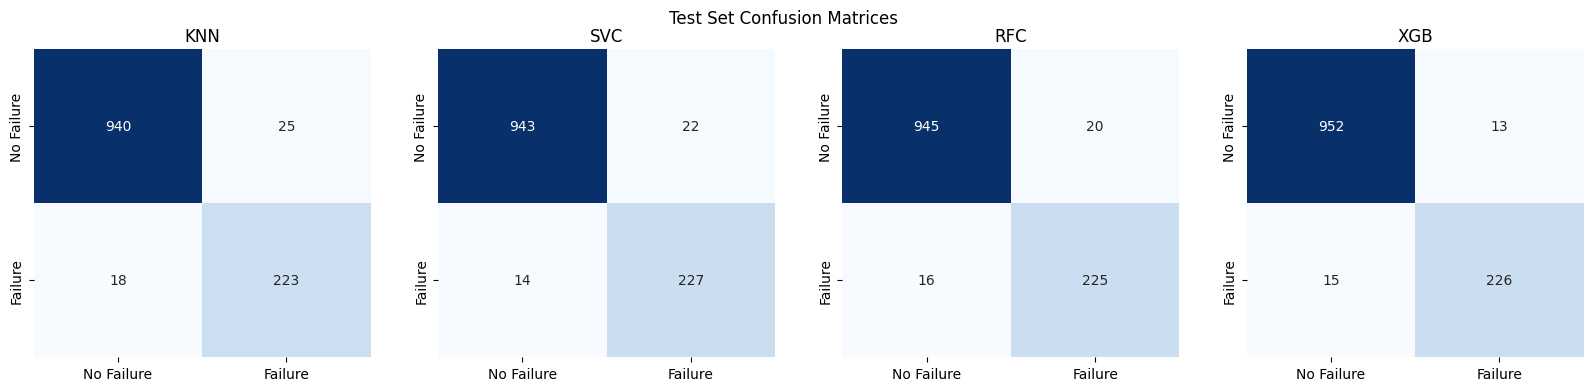


Validation Scores 
       KNN    SVC    RFC    XGB
ACC  0.968  0.973  0.976  0.986
AUC  0.957  0.992  0.997  0.999
F1   0.922  0.934  0.940  0.965
F2   0.931  0.941  0.948  0.971

Test set Scores
       KNN    SVC    RFC    XGB
ACC  0.964  0.970  0.970  0.977
AUC  0.950  0.989  0.996  0.998
F1   0.912  0.927  0.926  0.942
F2   0.920  0.936  0.931  0.939


In [146]:
# show validation confusion matrices

fig, axs = plt.subplots(ncols=4, figsize = (20,4))
fig.suptitle('Validation Set Confusion Matrices')

for j, model_name in enumerate(clf_str):
  ax = axs[j]
  sns.heatmap(ax=ax, data = cm_dict_val[model_name], annot = True,
              fmt = 'd', cmap = 'Blues', cbar = False)
  ax.title.set_text(model_name)
  ax.set_xticklabels(cm_labels)
  ax.set_yticklabels(cm_labels)
plt.show()

# show test confusion matrices

fig, axs = plt.subplots(ncols=4, figsize = (20,4))
fig.suptitle('Test Set Confusion Matrices')

for j, model_name in enumerate(clf_str):
  ax = axs[j]
  sns.heatmap(ax=ax, data = cm_dict_test[model_name], annot = True,
            fmt = 'd', cmap = 'Blues', cbar = False)
  ax.title.set_text(model_name)
  ax.set_xticklabels(cm_labels)
  ax.set_yticklabels(cm_labels)
plt.show()

print('')
# print the scores

print('Validation Scores ',metrics_val, sep='\n')
print()
print('Test set Scores', metrics_test, sep='\n')


- with the only exception of KNN. In particular KNN obtains the worst performances and XGB the best ones;
- in the middle we find SVC and RFC which achieve extremely similar results.

In [147]:
# we have to findout which feature is more important while predicting accuracy

# Evaluat the Permutation feature importance

f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()

for clf in fitted_models_binary:
  result = permutation_importance(clf, X_train, y_train['Target'],
                                  scoring = f2_scorer, random_state=0)
  result_mean = pd.Series(data=result.importances_mean, index = X.columns)
  importances = pd.concat(objs=[importances, result_mean], axis=1)
importances.columns = clf_str

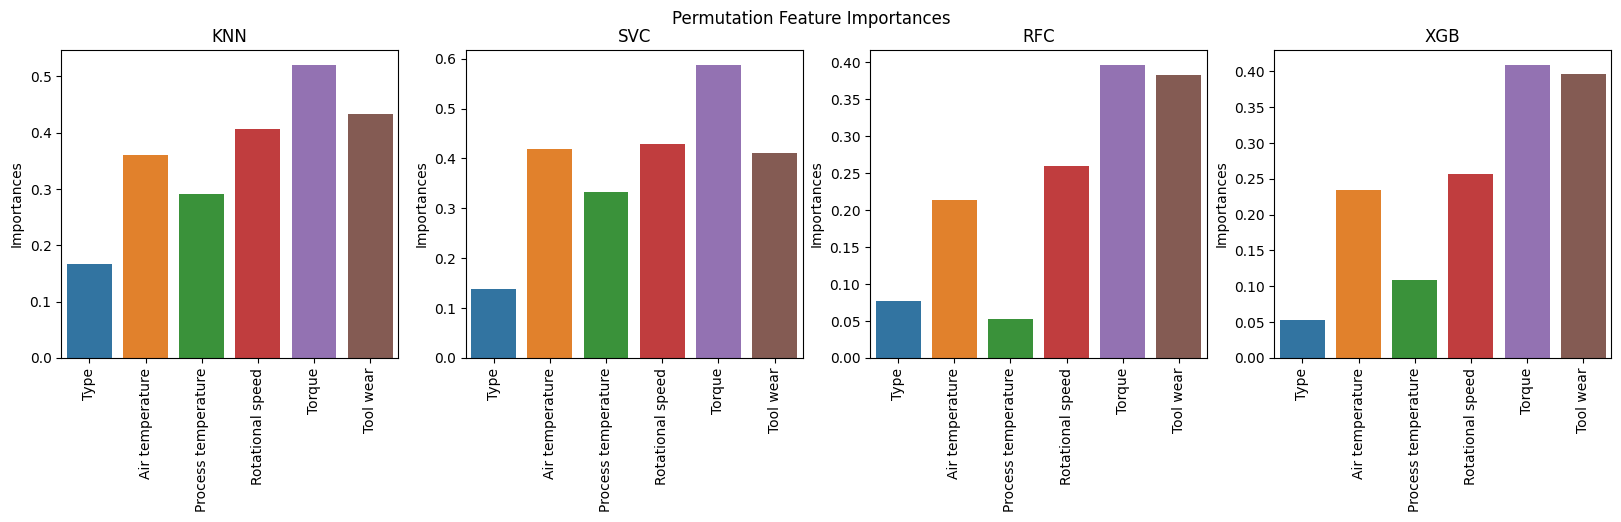

In [148]:
# bar plot for feature importance

fig, axs = plt.subplots(ncols = 4, figsize = (20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
  sns.barplot(ax = axs[j], x = importances.index, y = importances[name].values)
  axs[j].tick_params('x', labelrotation = 90)
  axs[j].set_ylabel('Importances')
  axs[j].title.set_text(str(name))

plt.show()


> Remarks:

- Type is the feature with the lowest significance
- importance remains strictly positive in each of the cases considered and therefore removing it completely would have led to a decline in prediction performance, not justified by a significant computational gain
- Unlike Logistic Regression, the models tested place great emphasis on Tool wear as well as Torque and Rotational Speed.
- Since the former alone is related to a specific category of failures and strongly distorts the kdeplot of Machine failure, we have a sign that our models still worked well.

## 4) Multi- Class Task

> task-2

- second task not only predict failure. here we need to identify what kind of failure will be come when machine failure.



---
- For multiclass targets, when we calculate the values of AUC, F1 and F2 scores, we need to set the parameter "average". We choose "average=weighted", in order to account for class imbalance: in fact, at the end of data preprocessing, we have 80% WORKING machine and 20% that fail.
- While many classification algorithms (such as K-nearest neighbor, Random Forest and XGBoost) naturally permit the use of more than two classes,
- some (like Logistic Regression and Support Vector Machines) are by nature binary algorithms;
- For our project, we decide to use "OnevsRest" approach, who involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. We choose it because it is computationally more efficient than other types of approach.



In [149]:
X_val.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
10078,0,1.573255,0.963401,-1.006789,1.005069,-0.457073
9952,0,-0.814739,-1.209888,-0.891901,0.710533,1.022865
11275,0,-0.144373,-0.616091,-0.709566,1.985451,-0.409417
5367,0,1.396430,1.636619,0.076220,-0.391371,1.141260
6526,0,0.642623,0.525787,0.927808,-1.049097,-0.101888


Validation Set Metrics 
ACC    0.925
AUC    0.984
F1     0.910
F2     0.918
dtype: float64
Test Set Metrics 
ACC    0.918
AUC    0.983
F1     0.899
F2     0.909
dtype: float64


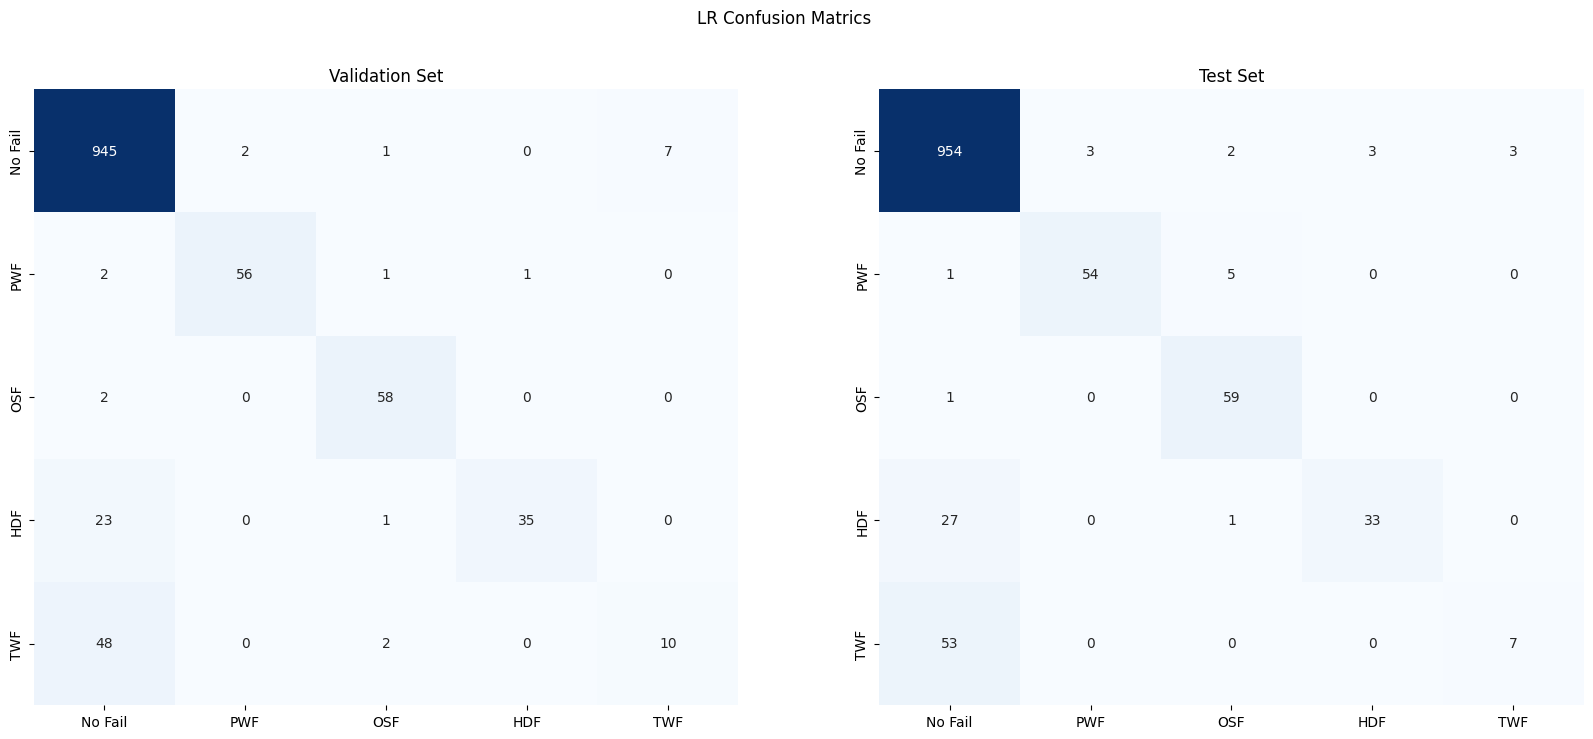

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.834445,0.217766,2.879209,0.103857,0.058382,0.275871
Power Failure,0.722221,1.003013,0.850618,1036.987729,3103.529465,0.792565
Tool Wear Failure,0.028082,0.224489,2.644566,0.130844,9.560100,382.511793
Overstrain Failure,0.674223,3877.101398,0.004486,0.000425,0.352494,0.719299
Heat Dissipation Failure,1.151017,1.436254,0.741691,0.198861,0.109464,707.867263


In [156]:
# Lets look into how Logistic regression for benchmark behaves

# multi-class classification

lr = LogisticRegression(random_state = 0, multi_class = 'ovr')
lr.fit(X_train, y_train['Failure Type'])

y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')

cm_test_lr, metrics_test_lr = eval_preds(lr, X_test, y_test, y_test_lr, 'multi_class')

print('Validation Set Metrics ', metrics_val_lr, sep='\n')
print('Test Set Metrics ',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail', 'PWF', 'OSF', 'HDF','TWF']

# show confusion matrices
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
fig.suptitle('LR Confusion Matrics')

for j, title in enumerate(['Validation Set', 'Test Set']):
  ax = axs[j]
  sns.heatmap(ax = ax, data = cm_lr[j], annot = True,
              fmt = 'd', cmap = 'Blues', cbar = False)
  axs[j].title.set_text(title)
  axs[j].set_xticklabels(cm_labels)
  axs[j].set_yticklabels(cm_labels)

plt.show()

# Odds for interpretation
print()
print()
odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

Observations:

- for example, power failure occurs only rotational speed and torque values are very hiigh.

In [157]:
# Models

knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()

clf = [knn, svc, rfc, xgb]
clf_str = ['KNN', 'SVC', 'RFC', 'XGB']


knn_params = {'n_neighbors':[1,3,5,8,10]}

svc_params = {'C':[1,10,100],
              'gamma':[0.1, 1],
              'kernel':['rbf'],
              'probability':[True],
              'random_state':[0]}

rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}

xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.11, 0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params, svc_params, rfc_params, xgb_params], index = clf)


In [162]:
# tune the hyper parameters with gridsearch (estimated time 8-10m)

print('GridSearch Start')
fitted_models_multi = []

for model, model_name in zip(clf, clf_str):
  print('Training '+str(model_name))
  fit_model = tune_and_fit(model, X_train, y_train, params[model], 'multi_class')
  fitted_models_multi.append(fit_model)

GridSearch Start
Training KNN
Best Params :  {'n_neighbors': 1}
Training time : 0m 6s
Training SVC
Best Params :  {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time : 2m 32s
Training RFC
Best Params :  {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time : 3m 26s
Training XGB
Best Params :  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time : 3m 25s


In [163]:
# create evaluation metrics

task = 'multi_class'

y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi, X_val, y_val, clf_str, task)

y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi, X_test, y_test, clf_str, task)

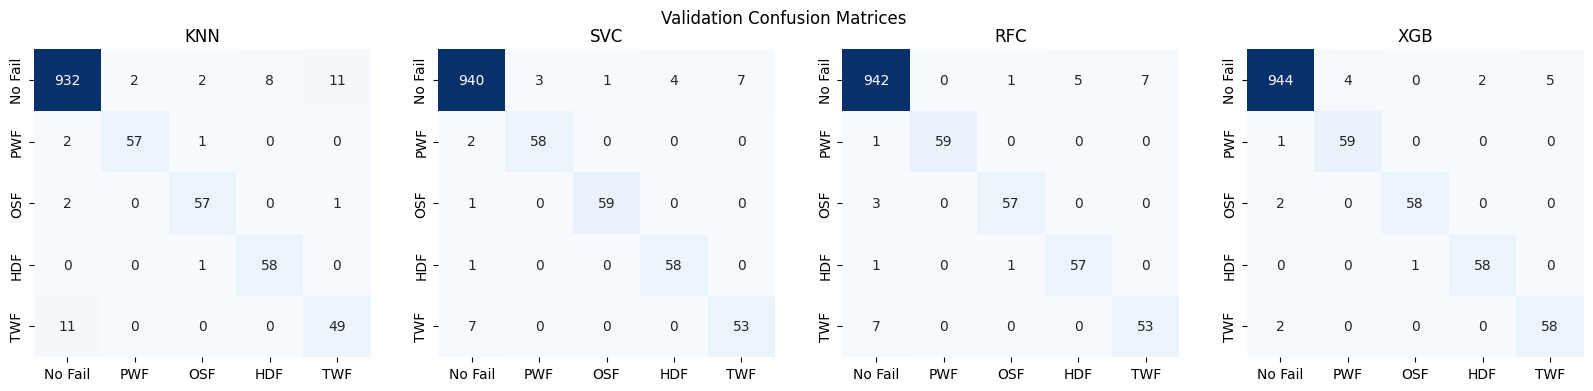

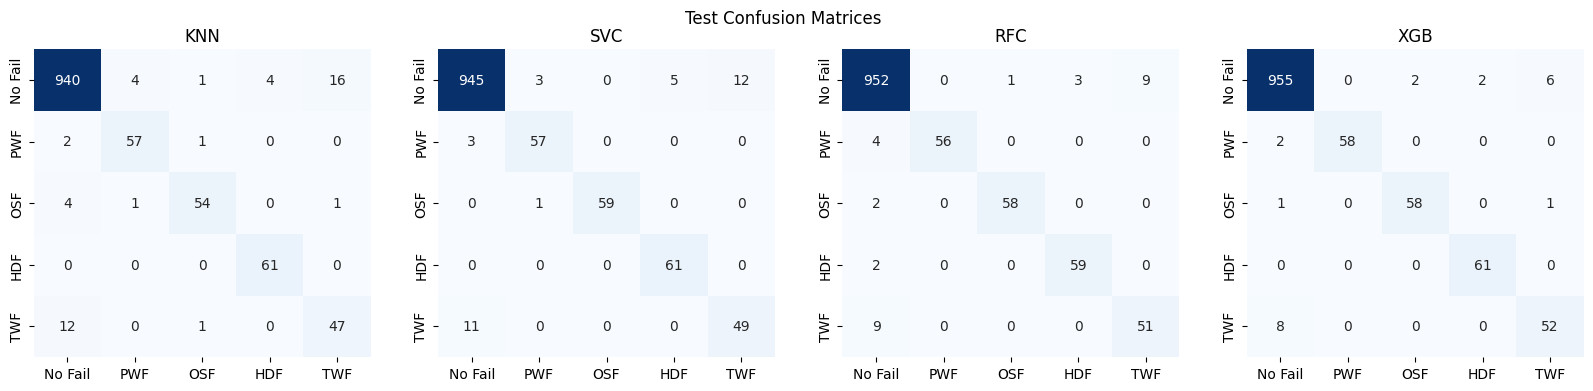



Validation Confusion Matrices 
       KNN    SVC    RFC    XGB
ACC  0.966  0.978  0.978  0.986
AUC  0.957  0.997  0.998  0.999
F1   0.966  0.978  0.978  0.986
F2   0.966  0.978  0.978  0.986
Test Confusion Matrices 
       KNN    SVC    RFC    XGB
ACC  0.961  0.971  0.975  0.982
AUC  0.950  0.988  0.997  0.999
F1   0.961  0.971  0.975  0.982
F2   0.961  0.971  0.975  0.982


In [167]:
# show validation confusion matrices

fig, axs = plt.subplots(ncols=4, figsize = (20,4))
fig.suptitle('Validation Confusion Matrices')

for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data = cm_dict_val[model_name], annot=  True,
                fmt = 'd', cmap='Blues', cbar = False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# show test set confusion matrices

fig, axs = plt.subplots(ncols=4, figsize = (20,4))
fig.suptitle('Test Confusion Matrices')

for j, model_name in enumerate(clf_str):
  ax = axs[j]
  sns.heatmap(ax=ax, data = cm_dict_test[model_name], annot = True,
              fmt = 'd', cmap='Blues', cbar = False)
  ax.title.set_text(model_name)
  ax.set_xticklabels(cm_labels)
  ax.set_yticklabels(cm_labels)
plt.show()


print()
print()
print('Validation Confusion Matrices ', metrics_val, sep='\n')
print('Test Confusion Matrices ', metrics_test, sep='\n')


> observation results

- We can see that KNN is performed very poor when compared to other estimators. when we want to know quick solution then we can choose KNN
- SVC and RFC performs extreamly similar.
- XGB got high performance. when we have more time then we can choose XGB.


In [169]:
# Permutation Feature Importance

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()

for clf in fitted_models_multi:
  result = permutation_importance(clf, X_train, y_train['Failure Type'],
                                  scoring = f2_scorer, random_state=0)
  result_mean = pd.Series(data = result.importances_mean, index = X.columns)
  importances = pd.concat(objs=[importances, result_mean], axis=1)

importances.columns = clf_str

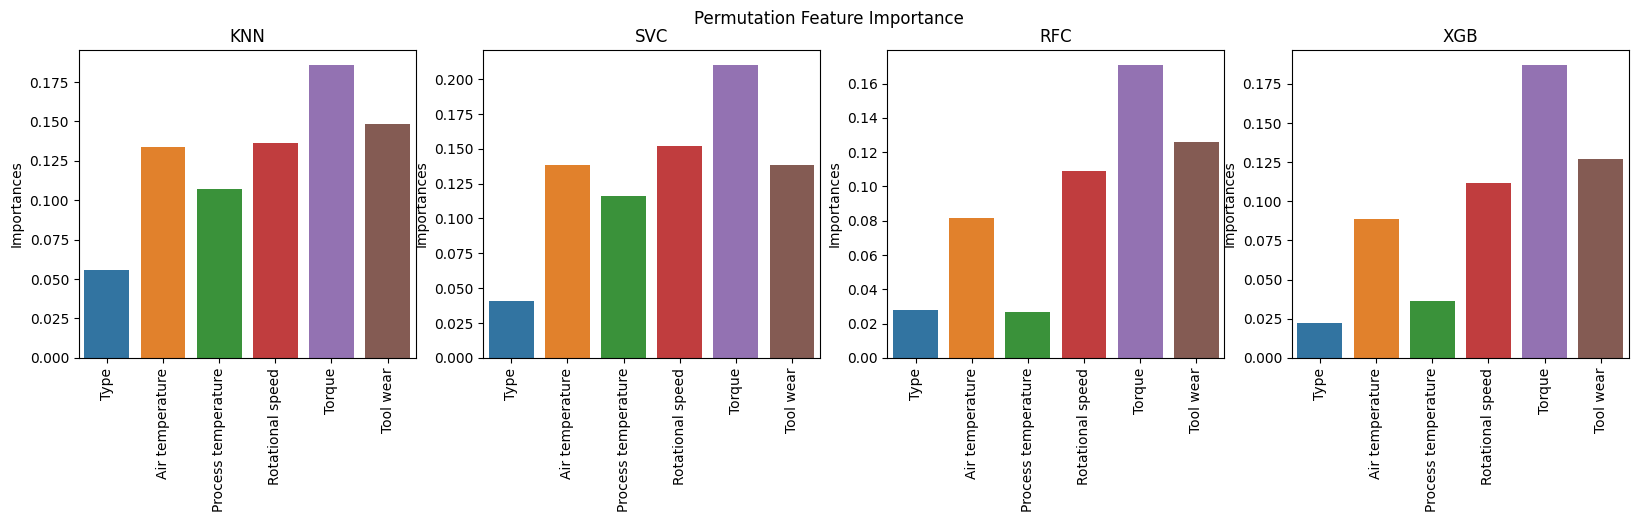

In [170]:
# bar plot for the feature importance

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importance')

for j, name in enumerate(clf_str):
  sns.barplot(ax=axs[j], x = importances.index, y = importances[name].values)
  axs[j].tick_params('x', labelrotation=90)
  axs[j].set_ylabel('Importances')
  axs[j].title.set_text(str(name))
plt.show()

> observation results

- K-NN is the one who gives more importance to Type, but, different from binary case,
- here we see that for every model the Type contribution is almost zero.
- For K-NN and SVC there is an insignificant improvement in the metrics’ values, which were already very good.
-For RFC and XGB we do not see any change on metrics’ values. Since the training time for the different models is approximately equal in both cases,
---

**we let users choose which dataset to use.**
to know this we have to see decision path segment

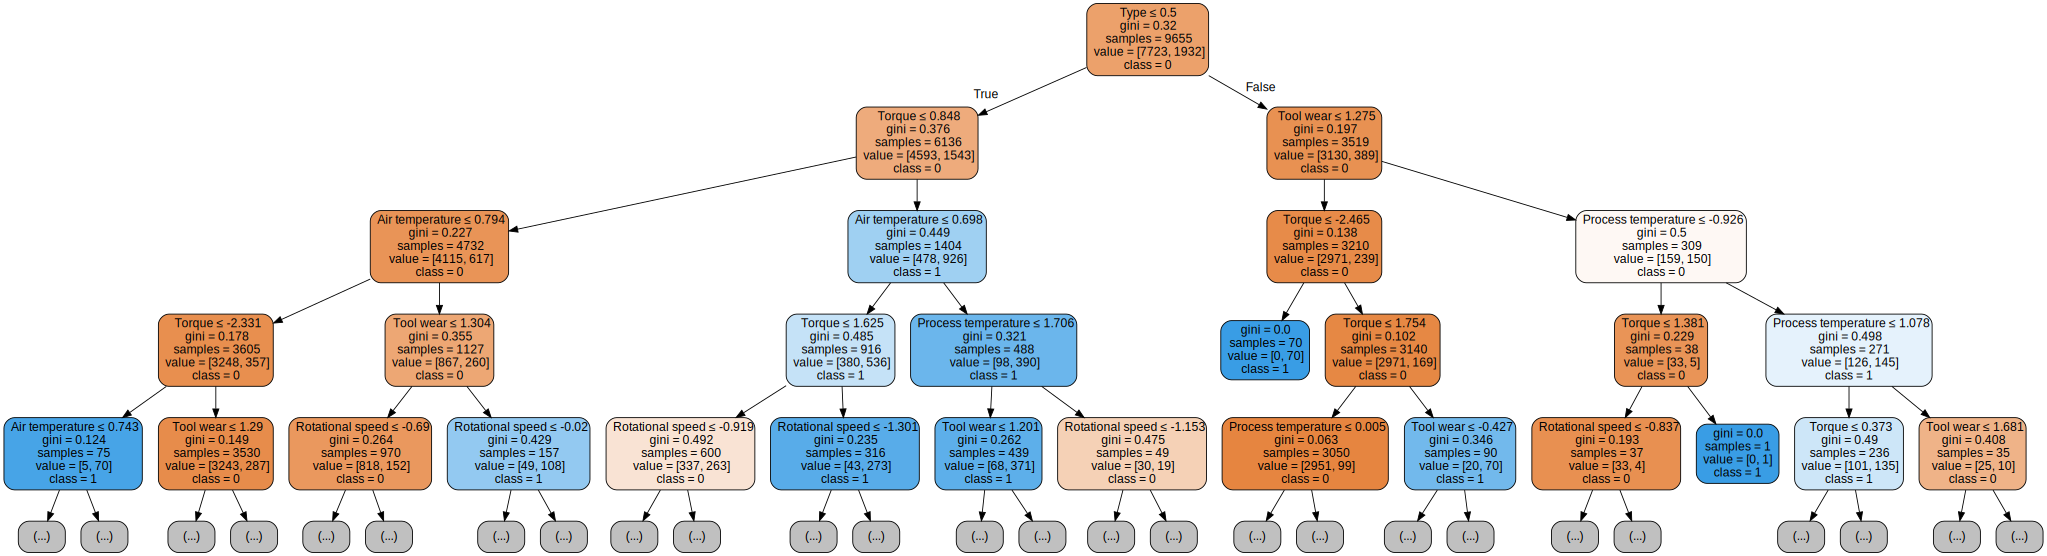

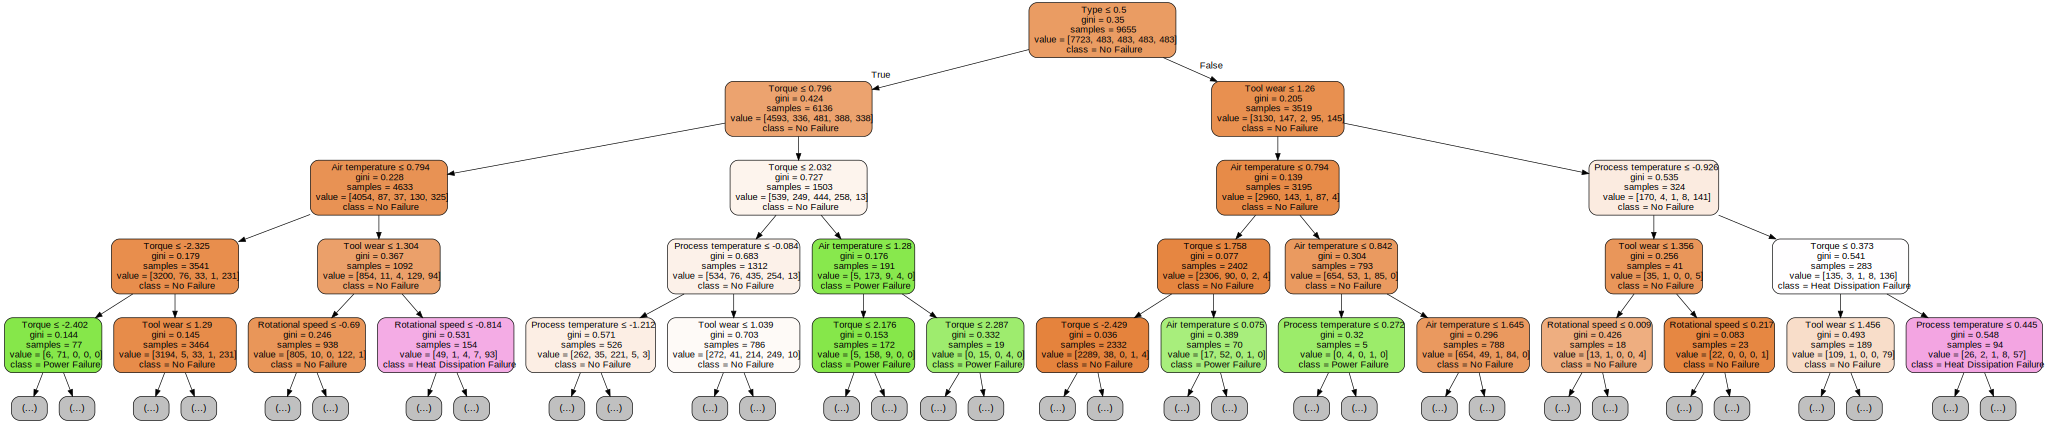

In [173]:
# Random Forest Decision Path

from sklearn import tree
import graphviz

tree_binary = fitted_models_binary[2].best_estimator_.estimators_[0]
tree_multi = fitted_models_multi[2].best_estimator_.estimators_[0]

trees = [tree_binary, tree_multi]

targets = ['Target' , 'Failure Type']

for decision_tree, target in zip(trees, targets):
  decision_tree.fit(X_train, y_train[target])
  classes = list(map(str, df_res[target].unique()))

  dot_data = tree.export_graphviz(decision_tree, out_file= None,
                                  feature_names = X.columns,
                                  class_names = classes,
                                  filled = True, rounded = True,
                                  special_characters = True,
                                  max_depth = 4, ) # uncomment see the full tree

  graph = graphviz.Source(dot_data)
  graph.render(target+" Classification tree")
  display(graph)


##Conclusion about the Predictive Maintenance Project:
- According to the analyses carried out and the results obtained, it is possible to make some conclusive considerations related to this project.
- We decided to tackle two tasks:
- predict whether a machine will fail or not and
- predict the type of failure that will occur.
---
- Before developing the models we did data preprocessing to ensure the validity of the assumptions of applicability of the models and ensure the best performances.
- Briefly, in the preprocessing phase we have deleted some ambiguous samples,
- We applied a label encoding to the categorical columns and then we performed the scaling of the columns with StandardScaler.
- We also noticed the presence of some data points which at first we referred to as outliers but later turned out to be part of the natural variance of the data and played an important role in the classification task.
- Then we ran PCA and found that most of the variance is explained by the first three components, that can be represented as the following features:  
 1. combination of the two Temperatures,
 2. Machine Power (product of Rotational Speed and Torque) and
 3. Tool Wear.

- In according to this, we found that these are the features that contribute the most in the predictions when apply the models.
- Contrary to logical predictions, we demonstrated that the machine’s type does not affect the presence of failure.

---

- At the end, we can conclude that for both task the chosen models perform very well
- For both tasks the best model is XGBoost and the worst is KNN;
- However, the response time of KNN is instant while XGBoost takes more time and this further increases when we proceed with the multi-class classification task.
- The choice of the model depends on the needs of the company:
- For faster applications one can use KNN while if one cares more about accuracy one can use XGBoost.
